Connect to google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import expit
sns.set_style('darkgrid')
from sklearn.model_selection import train_test_split
import math

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Load edge data set from csv file that contains positive and negative edges.

In [ ]:
data = pd.read_csv("/content/drive/My Drive/SML_Assignment1/current version/data_all.csv")
df = data.drop_duplicates()
# df, df_test = train_test_split(df, test_size=0.8)
df = df.astype('int')
print(len(df))
df.head()

349170


,source,sink,probability
0,3563811,2859978,0
1,2052043,2794848,0
2,4517994,1558154,0
3,1660006,2347784,0
4,581111,4414254,0


Generate directed edge dictionaries \\
The follow dictionary contains all the outward edges from source nodes and the follower dictionary contains inward egdes for sink nodes.



In [ ]:
def generate_dictionary():
    follow = dict()
    follower = dict()
    # We can find that all the nodes are in the sink, but not in the source (some edges are unknown)
    with open('/content/drive/My Drive/SML_Assignment1/train.txt') as file:
        for i in file:
            splited = i.strip().split()
            source = int(splited[0])
            sinks = splited[1:]
            for sink in sinks:
                sink = int(sink)
                follow[source] = follow.get(source, set())
                follow[source].add(sink)
                follower[sink] = follower.get(sink, set())
                follower[sink].add(source)
    print(follow[1000106])
    print("number of all nodes:")
    print(len(follower))
    print("number of source:")
    print(len(follow))
    return follow, follower

follow, follower = generate_dictionary()

{3047424, 2662401, 2842626, 4161543, 4808711, 3989513, 499721, 2351116, 3178510, 417807, 3260432, 2367507, 1351700, 3268627, 3244056, 4595743, 4055077, 712750, 1966134, 1032249, 3899454, 2777151, 696388, 3358789, 778310, 704586, 2826318, 3612752, 4653142, 1138774, 884822, 2523226, 3842143, 1310816, 4530278, 1982569, 3842154, 4276330, 3547243, 262256, 3522676, 2039924, 1810549, 4014197, 3752060, 1032323, 4153476, 2162824, 811152, 2310289, 3506323, 1319060, 606363, 2646172, 3235995, 1433759, 4006050, 3915941, 4087975, 3965095, 4079785, 3498157, 2171067, 3285180, 1474752, 2228419, 3023044, 4276421, 2015433, 2171085, 1229011, 1818835, 3023064, 4096218, 3956967, 1081582, 1638639, 327924, 1376501, 90359, 2670839, 2269434, 917755, 4677885, 3670270, 2457856, 1605894, 262, 2007311, 2867471, 2081045, 1278238, 4530462, 2769184, 2851104, 3637538, 2294055, 4702504, 606506, 1696048, 3588407, 3375416, 1319230, 33089, 1769796, 2605388, 3391821, 1499472, 803153, 3219795, 1360212, 4743511, 1573212, 4309

In [ ]:
train, test = train_test_split(df, test_size=0.01)
print(len(train))
print(len(test))

345678
3492


In [ ]:
train.head()

,source,sink,probability
19233,4019426,106379,0
38759,3018264,1179120,0
208249,262893,3361497,0
232242,400728,3085862,0
246704,998622,2990127,1


In [ ]:
test.head()

,source,sink,probability
229182,4152300,3809208,1
249067,753701,4842349,0
74354,3968287,4221236,1
339615,1983954,1470671,0
319402,2708149,1130218,1


Feature extraction

In [ ]:
import networkx as nx

def generate_graph():
  graph = nx.DiGraph()  # create a new graph


  for source in follow.keys():
    if source not in graph.nodes:
      graph.add_node(source)
          
    sinks = follow[source]
    for sink in sinks:
      if sink not in graph.nodes:
        graph.add_node(sink)
        
    graph.add_edge(source, sink)

  for sink in follower.keys():
    if sink not in graph.nodes:
      graph.add_node(sink)

    sources = follower[sink]
    for source in sources:
      if source not in graph.nodes:
        graph.add_node(source)

    graph.add_edge(source, sink)
  return graph

graph = generate_graph()

In [ ]:
def common_neighbors_totNum(nodeA, nodeB):
  A_neighbors = follow.get(nodeA, set())
  B_neighbors = follow.get(nodeB, set())
  common_neighbors = A_neighbors.intersection(B_neighbors)
  return len(common_neighbors)


# union
def neighbors_union_totNum (nodeA, nodeB):
  A_neighbors = follow.get(nodeA, set())
  B_neighbors = follow.get(nodeB, set())
  union_neighbors = A_neighbors.union(B_neighbors)
  return len(union_neighbors)


def common_fans_totNum(nodeA, nodeB):
  A_fans = follower[nodeA]
  B_fans = follower[nodeB]
  common_fans = A_fans.intersection(B_fans)
  return len(common_fans)


# union
def fans_union_totNum (nodeA, nodeB):
  A_fans = follower[nodeA]
  B_fans = follower[nodeB]
  total_fans = A_fans.union(B_fans)
  return len(total_fans)


def friend(node):
  return len(follow[node].intersection(follower[node]))

# non-linear of friend
def friend_circle(nodeA):
  return (friend(nodeA) * friend(nodeA))


def follow_friend(nodeA, nodeB):
  return len(follow[nodeA].intersection(follower[nodeB]))


def jaccard_outdegree(nodeA, nodeB):
  common_neighbors = common_neighbors_totNum(nodeA, nodeB)
  union_neighbors = neighbors_union_totNum(nodeA, nodeB)
  jacc = common_neighbors / (union_neighbors+1)    
  return jacc


def jaccard_indegree(nodeA, nodeB):
  common_fans = common_fans_totNum(nodeA, nodeB)
  union_fans = fans_union_totNum(nodeA, nodeB)
  jacc = common_fans / (union_fans+1)    
  return jacc


# Adamic/Adar (Frequency-Weighted Common Neighbors)  outdegree
def adamic_adar_out(nodeA, nodeB):
  A_neighbors = follow.get(nodeA, set())
  B_neighbors = follow.get(nodeB, set())  
  common_neighbors = (A_neighbors).intersection(B_neighbors)
  
  adar_score = 0
  for neighbor in common_neighbors:
    neighbors_neighbor = follow.get(neighbor, set())
    num_neighbors_neighbor = len(neighbors_neighbor)
    adar_score += 1 / math.log(num_neighbors_neighbor + 0.5)
        
  return adar_score

# Adamic/Adar (Frequency-Weighted Common Neighbors)  indegree
def adamic_adar_in(nodeA, nodeB):
  A_fans = follower.get(nodeA, set())
  B_fans = follower.get(nodeB, set())
  common_fans = (A_fans).intersection(B_fans) 
  
  adar_score = 0
  for fan in common_fans:
    fans_fan = follower.get(fan, set())
    num_fans_fan = len(fans_fan)
    adar_score += 1 / math.log(num_fans_fan + 0.5)
        
  return adar_score


# Non-linear
#  Preferential Attachment   
def preferential_attach(nodeA, nodeB):
  A_neighbors = follow.get(nodeA, set())
  B_neighbors = follow.get(nodeB, set())
  prefer_attach = len(A_neighbors) * len(B_neighbors)
  return prefer_attach


# for fans
def preferential_fans(nodeA, nodeB):
  A_neighbors = follow.get(nodeA, set())
  B_neighbors = follow.get(nodeB, set())
  prefer_attach = len(A_neighbors) * len(B_neighbors)
  return prefer_attach


#  salton index out
def salton_out(nodeA, nodeB):
    common_neighbors_num = common_neighbors_totNum(nodeA, nodeB)
    A_neighbors_num = len(follow.get(nodeA, set()))
    B_neighbors_num = len(follow.get(nodeB, set()))   
    salton_score = common_neighbors_num / (math.sqrt(A_neighbors_num*B_neighbors_num)+1)
    return salton_score


def salton_in(nodeA, nodeB):
    common_fans_num = common_fans_totNum(nodeA, nodeB)
    A_fan_num = len(follower.get(nodeA, set()))
    B_fan_num = len(follower.get(nodeB, set()))   
    salton_score = common_fans_num / (math.sqrt(A_fan_num*B_fan_num)+1)
    return salton_score


# Sorenson index
def sorenson_out(nodeA, nodeB):
    common_neighbors_num = common_neighbors_totNum(nodeA, nodeB)
    A_neighbors_num = len(follow.get(nodeA, set()))
    B_neighbors_num = len(follow.get(nodeB, set()))   
    sorenson_score = (2*common_neighbors_num) / (A_neighbors_num+B_neighbors_num+1)
    return sorenson_score

def sorenson_in(nodeA, nodeB):
    common_fans_num = common_fans_totNum(nodeA, nodeB)
    A_fan_num = len(follower.get(nodeA, set()))
    B_fan_num = len(follower.get(nodeB, set()))  
    sorenson_score = (2*common_fans_num) / (A_fan_num+B_fan_num+1)
    return sorenson_score    


# HPI
def hpi_out(nodeA, nodeB):
    common_neighbors_num = common_neighbors_totNum(nodeA, nodeB)
    A_neighbors_num = len(follow.get(nodeA, set()))
    B_neighbors_num = len(follow.get(nodeB, set()))  
    hpi_socre = common_neighbors_num / (min(A_neighbors_num,B_neighbors_num)+1)
    return hpi_socre

def hpi_in(nodeA, nodeB):
    common_fans_num = common_fans_totNum(nodeA, nodeB)
    A_fan_num = len(follower.get(nodeA, set()))
    B_fan_num = len(follower.get(nodeB, set())) 
    hpi_socre = common_fans_num / (min(A_fan_num,B_fan_num)+1)
    return hpi_socre    


# HDI
def hdi_out(nodeA, nodeB):
    common_neighbors_num = common_neighbors_totNum(nodeA, nodeB)
    A_neighbors_num = len(follow.get(nodeA, set()))
    B_neighbors_num = len(follow.get(nodeB, set())) 
    hdi_socre = common_neighbors_num / (max(A_neighbors_num,B_neighbors_num)+1)
    return hdi_socre

def hdi_in(nodeA, nodeB):
    common_fans_num = common_fans_totNum(nodeA, nodeB)
    A_fan_num = len(follower.get(nodeA, set()))
    B_fan_num = len(follower.get(nodeB, set())) 
    hdi_socre = common_fans_num / (max(A_fan_num,B_fan_num)+1)
    return hdi_socre


# LHN-I
def lhni_out(nodeA, nodeB):
    common_neighbors_num = common_neighbors_totNum(nodeA, nodeB)
    A_neighbors_num = len(follow.get(nodeA, set()))
    B_neighbors_num = len(follow.get(nodeB, set()))     
    lhni_socre = common_neighbors_num / (A_neighbors_num*B_neighbors_num+1)
    return lhni_socre


def lhni_in(nodeA, nodeB):
    common_fans_num = common_fans_totNum(nodeA, nodeB)
    A_fan_num = len(follower.get(nodeA, set()))
    B_fan_num = len(follower.get(nodeB, set()))    
    lhni_socre = common_fans_num / (A_fan_num*B_fan_num+1)
    return lhni_socre    


def shortest_path(nodeA, nodeB):
  if nx.has_path(graph, nodeA, nodeB):
    return nx.shortest_path_length(graph, source=nodeA, target=nodeB, weight=None)
  else:
    return 29

Feature generation and selection

In [ ]:
train["sink_fans"] = train.apply(lambda row: len(follower[row.sink]), axis=1)
train["source_fans"] = train.apply(lambda row: len(follower[row.source]), axis=1)
train["common_neighbor"] = train.apply(lambda row: common_neighbors_totNum(row.source, row.sink), axis=1)
train["union_neighbor"] = train.apply(lambda row: neighbors_union_totNum(row.source, row.sink), axis=1)
train["common_fans"] = train.apply(lambda row: common_fans_totNum(row.source, row.sink), axis=1)
train["total_fans"] = train.apply(lambda row: fans_union_totNum(row.source, row.sink), axis=1)
train["friend"] = train.apply(lambda row: friend(row.source), axis=1)
train["friend_circle"] = train.apply(lambda row: friend_circle(row.source), axis=1)
train["jaccard_indegree"] = train.apply(lambda row: jaccard_indegree(row.source, row.sink), axis=1)
train["jaccard_outdegree"] = train.apply(lambda row: jaccard_outdegree(row.source, row.sink), axis=1)
train["adamic_adar_out"] = train.apply(lambda row: adamic_adar_out(row.source, row.sink), axis=1)
train["adamic_adar_in"] = train.apply(lambda row: adamic_adar_in(row.source, row.sink), axis=1)
train["preferential_attach"] = train.apply(lambda row: preferential_attach(row.source, row.sink), axis=1)
train["preferential_fans"] = train.apply(lambda row: preferential_fans(row.source, row.sink), axis=1)
train["follow_friend"] = train.apply(lambda row: follow_friend(row.source, row.sink), axis=1)
train["salton_out"] = train.apply(lambda row: salton_out(row.source, row.sink), axis=1)
train["salton_in"] = train.apply(lambda row: salton_in(row.source, row.sink), axis=1)
train["sorenson_out"] = train.apply(lambda row: sorenson_out(row.source, row.sink), axis=1)
train["sorenson_in"] = train.apply(lambda row: sorenson_in(row.source, row.sink), axis=1)
train["hpi_out"] = train.apply(lambda row: hpi_out(row.source, row.sink), axis=1)
train["hpi_in"] = train.apply(lambda row: hpi_in(row.source, row.sink), axis=1)
train["hdi_out"] = train.apply(lambda row: hdi_out(row.source, row.sink), axis=1)
train["hdi_in"] = train.apply(lambda row: hdi_in(row.source, row.sink), axis=1)
train["lhni_out"] = train.apply(lambda row: lhni_out(row.source, row.sink), axis=1)
train["lhni_in"] = train.apply(lambda row: lhni_in(row.source, row.sink), axis=1)
train["shortest_path"] = train.apply(lambda row: shortest_path(row.source, row.sink), axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
train.head()

,source,sink,probability,sink_fans,source_fans,common_neighbor,union_neighbor,common_fans,total_fans,friend,friend_circle,jaccard_indegree,jaccard_outdegree,adamic_adar_out,adamic_adar_in,preferential_attach,preferential_fans,follow_friend,salton_out,salton_in,sorenson_out,sorenson_in,hpi_out,hpi_in,hdi_out,hdi_in,lhni_out,lhni_in,shortest_path
19233,4019426,106379,0,1,16,0,94,0,17,6,36,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29
38759,3018264,1179120,0,1,77,0,689,0,78,54,2916,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29
208249,262893,3361497,0,1,161,0,3792,0,162,135,18225,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29
232242,400728,3085862,0,1,21,0,137,0,22,11,121,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
246704,998622,2990127,1,1,66,0,792,0,67,60,3600,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


Delete test edges

In [ ]:
for row in test.itertuples():
  if row.probability == 1:
    follow[row.source].remove(row.sink)
    follower[row.sink].remove(row.source)

In [ ]:
test["sink_fans"] = test.apply(lambda row: len(follower[row.sink]), axis=1)
test["source_fans"] = test.apply(lambda row: len(follower[row.source]), axis=1)
test["common_neighbor"] = test.apply(lambda row: common_neighbors_totNum(row.source, row.sink), axis=1)
test["union_neighbor"] = test.apply(lambda row: neighbors_union_totNum(row.source, row.sink), axis=1)
test["common_fans"] = test.apply(lambda row: common_fans_totNum(row.source, row.sink), axis=1)
test["total_fans"] = test.apply(lambda row: fans_union_totNum(row.source, row.sink), axis=1)
test["friend"] = test.apply(lambda row: friend(row.source), axis=1)
test["friend_circle"] = test.apply(lambda row: friend_circle(row.source), axis=1)
test["jaccard_indegree"] = test.apply(lambda row: jaccard_indegree(row.source, row.sink), axis=1)
test["jaccard_outdegree"] = test.apply(lambda row: jaccard_outdegree(row.source, row.sink), axis=1)
test["adamic_adar_out"] = test.apply(lambda row: adamic_adar_out(row.source, row.sink), axis=1)
test["adamic_adar_in"] = test.apply(lambda row: adamic_adar_in(row.source, row.sink), axis=1)
test["preferential_attach"] = test.apply(lambda row: preferential_attach(row.source, row.sink), axis=1)
test["preferential_fans"] = test.apply(lambda row: preferential_fans(row.source, row.sink), axis=1)
test["follow_friend"] = test.apply(lambda row: follow_friend(row.source, row.sink), axis=1)
test["salton_out"] = test.apply(lambda row: salton_out(row.source, row.sink), axis=1)
test["salton_in"] = test.apply(lambda row: salton_in(row.source, row.sink), axis=1)
test["sorenson_out"] = test.apply(lambda row: sorenson_out(row.source, row.sink), axis=1)
test["sorenson_in"] = test.apply(lambda row: sorenson_in(row.source, row.sink), axis=1)
test["hpi_out"] = test.apply(lambda row: hpi_out(row.source, row.sink), axis=1)
test["hpi_in"] = test.apply(lambda row: hpi_in(row.source, row.sink), axis=1)
test["hdi_out"] = test.apply(lambda row: hdi_out(row.source, row.sink), axis=1)
test["hdi_in"] = test.apply(lambda row: hdi_in(row.source, row.sink), axis=1)
test["lhni_out"] = test.apply(lambda row: lhni_out(row.source, row.sink), axis=1)
test["lhni_in"] = test.apply(lambda row: lhni_in(row.source, row.sink), axis=1)
test["shortest_path"] = test.apply(lambda row: shortest_path(row.source, row.sink), axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
test.head()

,source,sink,probability,sink_fans,source_fans,common_neighbor,union_neighbor,common_fans,total_fans,friend,friend_circle,jaccard_indegree,jaccard_outdegree,adamic_adar_out,adamic_adar_in,preferential_attach,preferential_fans,follow_friend,salton_out,salton_in,sorenson_out,sorenson_in,hpi_out,hpi_in,hdi_out,hdi_in,lhni_out,lhni_in,shortest_path
229182,4152300,3809208,1,40,48,0,120,7,81,37,1369,0.085366,0.0,0.0,1.037598,0,0,6,0.0,0.156188,0.0,0.157303,0.0,0.170732,0.0,0.142857,0.0,0.003644,29
249067,753701,4842349,0,1,12,0,135,0,13,4,16,0.000000,0.0,0.0,0.000000,0,0,0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,29
74354,3968287,4221236,1,0,21,0,126,0,21,14,196,0.000000,0.0,0.0,0.000000,0,0,0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,1
339615,1983954,1470671,0,26,25,0,49,0,51,12,144,0.000000,0.0,0.0,0.000000,0,0,0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,29
319402,2708149,1130218,1,143,85,0,1798,10,218,81,6561,0.045662,0.0,0.0,1.412833,0,0,10,0.0,0.089888,0.0,0.087336,0.0,0.116279,0.0,0.069444,0.0,0.000823,29


In [ ]:
# features = ["sink_fans", "source_fans", "common_neighbor", "union_neighbor", "common_fans", "total_fans", "friend", "friend_circle", "jaccard_indegree", "jaccard_outdegree", "adamic_adar_in", "adamic_adar_out", "preferential_attach", "preferential_fans", "salton_out", "salton_in", "hdi_in", "hdi_in", "hpi_in", "hpi_out", "sorenson_in", "sorenson_out", "follow_friend", "lhni_in", "lhni_out", "shortest_path"]
features = ["common_neighbor", "union_neighbor", "common_fans", "total_fans", "friend", "friend_circle", "jaccard_indegree", "jaccard_outdegree", "adamic_adar_in", "adamic_adar_out", "preferential_attach", "preferential_fans", "salton_out", "salton_in", "hdi_in", "hdi_out", "hpi_in", "hpi_out", "sorenson_in", "sorenson_out", "follow_friend", "lhni_in", "lhni_out", "shortest_path"]
X_train, X_test = train[features], test[features]
y_train, y_test = train["probability"], test["probability"]

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5]),
 <a list of 29 Text major ticklabel objects>)

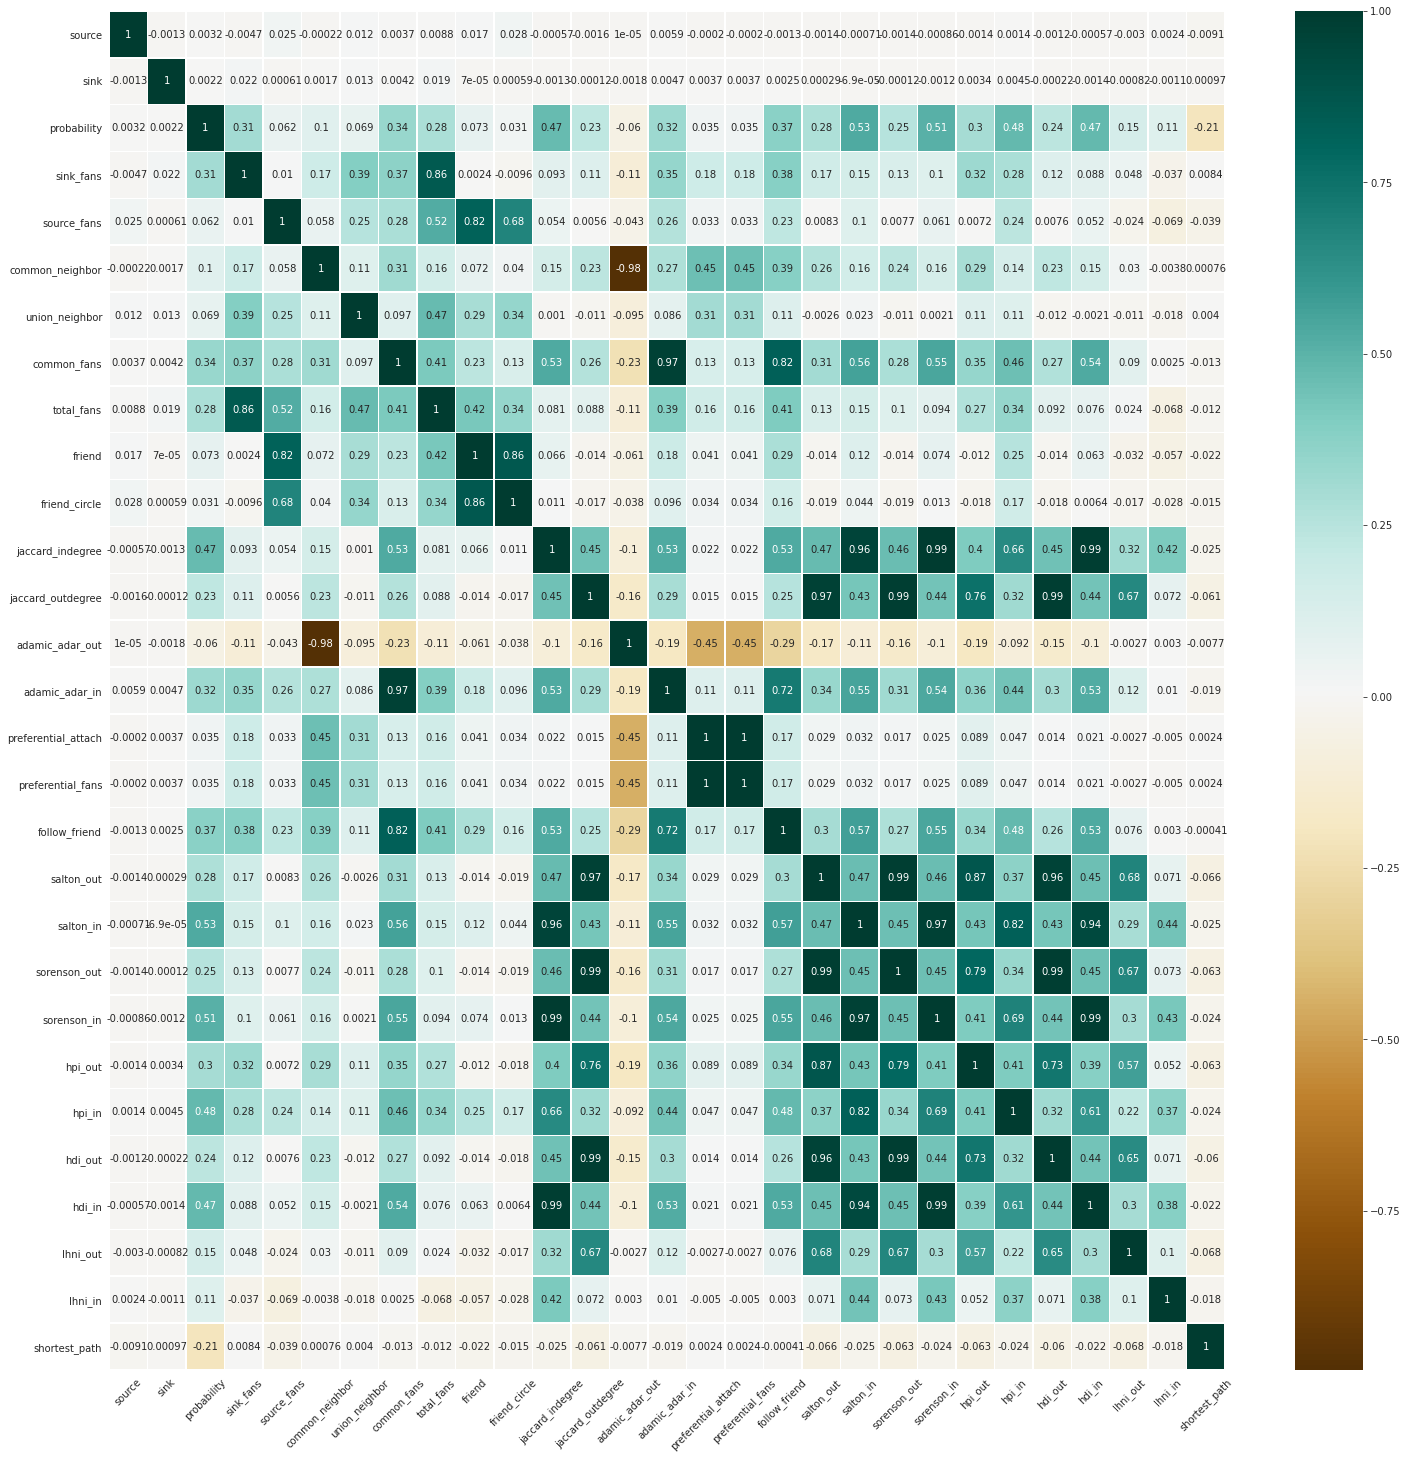

In [ ]:
plt.figure(figsize=(25,25))
sns.heatmap(train.corr(),cmap='BrBG',annot=True,
           linewidths=.5)
plt.xticks(rotation=45)

In [ ]:
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier,ExtraTreesClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV,cross_val_score,StratifiedKFold
from lightgbm import LGBMClassifier

# set k-fold validation set
kfold=StratifiedKFold(n_splits=5)

# different models
classifiers=[]
classifiers.append(SVC())
classifiers.append(DecisionTreeClassifier())
classifiers.append(RandomForestClassifier())
classifiers.append(ExtraTreesClassifier())
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression())
classifiers.append(LinearDiscriminantAnalysis())
classifiers.append(LGBMClassifier())

cv_results=[]
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier,X_train,y_train,
                                      scoring='roc_auc',cv=kfold))
    
cv_means=[]
cv_std=[]
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    
cvResDf=pd.DataFrame({'cv_mean':cv_means,
                     'cv_std':cv_std,
                     'algorithm':['SVC','DecisionTreeCla','RandomForestCla','ExtraTreesCla',
                                'KNN','LR','LinearDiscrimiAna', 'lightGBM']})

cvResDf

,cv_mean,cv_std,algorithm
0,0.668167,0.008802,SVC
1,0.746020,0.023748,DecisionTreeCla
2,0.865522,0.012560,RandomForestCla
3,0.854920,0.014962,ExtraTreesCla
4,0.680933,0.014313,KNN
5,0.856216,0.012741,LR
6,0.780639,0.014711,LinearDiscrimiAna
7,0.879397,0.009557,lightGBM


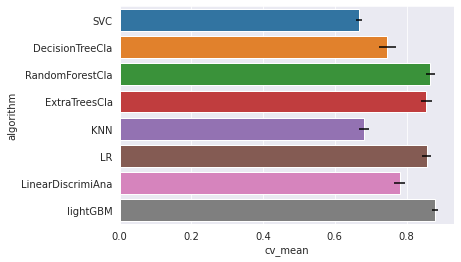

In [ ]:
sns.barplot(data=cvResDf,x='cv_mean',y='algorithm',**{'xerr':cv_std})

Fit simple gradient boosting model (without cross-validation), compare accuacy to the test set that we split above.

In [ ]:
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier,ExtraTreesClassifier
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)

gb.score(X_test, y_test)

0.9395761741122566

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


0.9395761741122566


<Figure size 1440x1440 with 0 Axes>

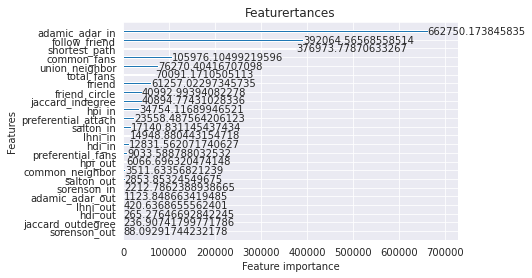

In [ ]:
from lightgbm import LGBMClassifier
import matplotlib.pylab as plt
import lightgbm as lgb

lightGBM = LGBMClassifier(objective = 'binary',
                         is_unbalance = True,
                         metric = 'binary_logloss,auc',
                         max_depth = 8,
                         num_leaves = 40,
                         learning_rate = 0.1,
                         feature_fraction = 0.6,
                         min_child_samples = 18,
                         min_child_weight=0.001,
                         bagging_fraction = 0.8,
                         bagging_freq = 2,
                         reg_alpha = 0.001,
                         reg_lambda = 8,
                         cat_smooth = 0,
                         num_iterations = 685)
model = lightGBM.fit(X_train, y_train)
print(lightGBM.score(X_test, y_test))

plt.figure(figsize=(20,20))
lgb.plot_importance(model, importance_type="gain", max_num_features=30)
plt.title("Featurertances")
plt.show()

Parameter Tuning

In [ ]:
parameters = {
    'reg_alpha': [0, 0.001, 0.01, 0.03, 0.08, 0.3, 0.5],
    'reg_lambda': [0, 0.001, 0.01, 0.03, 0.08, 0.3, 0.5]
}
lgbm = lgb.LGBMClassifier(objective = 'binary',
                         is_unbalance = True,
                         metric = 'binary_logloss,auc',
                         max_depth = 10,
                         num_leaves = 500,
                         learning_rate = 0.1,
                         feature_fraction = 0.6,
                         min_child_samples = 21,
                         min_child_weight=0.001,
                         bagging_fraction = 0.9,
                         bagging_freq = 2,
                         reg_alpha = 0.001,
                         reg_lambda = 8,
                         cat_smooth = 0,
                         num_iterations = 200,  
                        )
gsearch = GridSearchCV(lgbm, param_grid=parameters, scoring='roc_auc', cv=3)
gsearch.fit(X_train, y_train)
print('Best parameter:{0}'.format(gsearch.best_params_))
print('Best score:{0}'.format(gsearch.best_score_))
print(gsearch.cv_results_['mean_test_score'])
print(gsearch.cv_results_['params'])

In [ ]:
params = {

'objective': 'binary',
'metric': 'auc',
'learning_rate':0.1,
'num_leaves':500, 
'max_depth': 10,         
 'is_unbalance' : True,
 'feature_fraction' : 0.6,
 'min_child_samples' : 21,
 'min_child_weight' : 0.001,
 'bagging_fraction' : 0.9,
 'bagging_freq' : 2,
 'reg_alpha' : 0.08,
 'reg_lambda' : 0.03,
    }

data_train = lgb.Dataset(X_train, y_train, silent=True)
cv_results = lgb.cv(params, data_train, num_boost_round=1000, nfold=3, stratified=False, shuffle=True, metrics='auc')
print('best n_estimators:', len(cv_results['auc-mean']))
print('best cv score:', pd.Series(cv_results['auc-mean']).max())

[LightGBM] [Info] Number of positive: 130953, number of negative: 146113
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5884
[LightGBM] [Info] Number of data points in the train set: 277066, number of used features: 24
[LightGBM] [Info] Number of positive: 130805, number of negative: 146261
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011802 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5884
[LightGBM] [Info] Number of data points in the train set: 277066, number of used features: 24
[LightGBM] [Info] Number of positive: 130908, number of negative: 146158
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the ov

生成public-test数据特征

In [ ]:
df_public = pd.read_csv("/content/drive/My Drive/SML_Assignment1/current version/test-feature-new.csv")
df_public.head()

,source,sink,sink_fans,source_fans,common_neighbor,union_neighbor,common_fans,total_fans,friend,friend_circle,jaccard_indegree,jaccard_outdegree,adamic_adar_out,adamic_adar_in,preferential_attach,preferential_fans,follow_friend,salton_out,salton_in,sorenson_out,sorenson_in,hpi_out,hpi_in,hdi_out,hdi_in,lhni_out,lhni_in,shortest_path
0,3563811,3600160,29,3,0,21,0,32,1,1,0.000000,0.0,0.0,0.000000,0,0,0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,29
1,2052043,1401960,9,13,0,71,0,22,10,100,0.000000,0.0,0.0,0.000000,0,0,0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,29
2,4517994,1690636,17,80,0,205,2,95,30,900,0.020833,0.0,0.0,0.454066,0,0,2,0.0,0.052801,0.0,0.040816,0.0,0.111111,0.0,0.024691,0.0,0.001470,29
3,1660006,4349447,36,32,0,506,2,66,27,729,0.029851,0.0,0.0,0.263118,0,0,2,0.0,0.057239,0.0,0.057971,0.0,0.060606,0.0,0.054054,0.0,0.001735,29
4,581111,1882617,46,5,0,18,0,51,2,4,0.000000,0.0,0.0,0.000000,0,0,0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,7


Correlation for test data

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5]), <a list of 23 Text major ticklabel objects>)

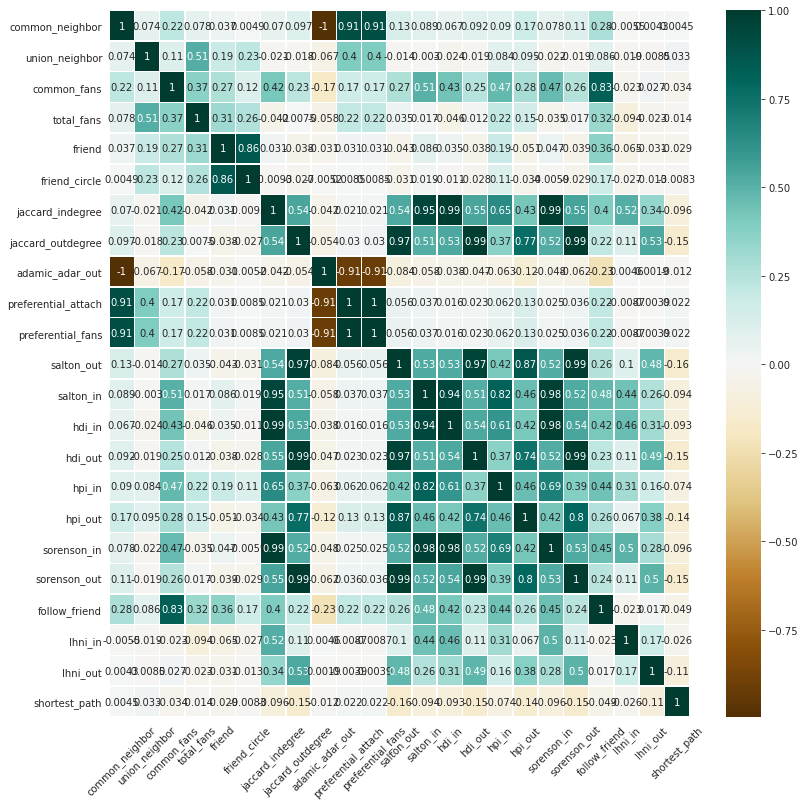

In [ ]:
plt.figure(figsize=(13,13))
sns.heatmap(df_public[features].corr(),cmap='BrBG',annot=True,
           linewidths=.5)
plt.xticks(rotation=45)

Predict by trained model

In [ ]:
y_pred = lightGBM.predict_proba(df_public[features])
print(y_pred)

[[0.77408827 0.22591173]
 [0.91864044 0.08135956]
 [0.05574006 0.94425994]
 ...
 [0.96485508 0.03514492]
 [0.96257132 0.03742868]
 [0.68055773 0.31944227]]


观察数据分布

In [ ]:
from scipy import stats
pred = lightGBM.predict(df_public[features])
stats.describe(pred)

DescribeResult(nobs=2000, minmax=(0, 1), mean=0.5875, variance=0.24246498249124562, skewness=-0.355485701283318, kurtosis=-1.8736299161831078)

Save predicted data to csv

In [ ]:
import csv
filename = "/content/drive/My Drive/SML_Assignment1/test-result.csv"
    
# writing to csv file  
with open(filename, 'w') as csvfile:
  csvfile.truncate()  # clear csv
  csvwriter = csv.writer(csvfile)
  header = ["Id", "Predicted"]
  csvwriter.writerow(header)
  for i in range(1, 2001): 
    csvwriter.writerow([i, y_pred[i-1][1]]) 